scrapy의 과정을 이해하기 위한 예시 2번째 : Naver Movie  
1. 프로젝트 생성
2. items 설정
3. xpath 확인
4. pipelines
5. settings.py

## Naver Movie
- robots.txt 설정으로 크롤링 안된다. 
- -> settings.py에 robots.txt 설정을 바꿔서 크롤링하면 크롤링이 가능해진다.

### 1. 프로젝트 생성

In [1]:
!scrapy startproject naver_movie

Error: scrapy.cfg already exists in /home/ubuntu/02.Crawling/06.scrapy/naver_movie


### 2. items 설정
- https://movie.naver.com/movie/running/current.nhn
- 제목, 관객수, 평점

In [2]:
# ! cat naver_movie/naver_movie/items.py

In [3]:
%%writefile naver_movie/naver_movie/items.py
import scrapy

class NaverMovieItem(scrapy.Item):  # Field()는 대문자니까 클래스!!
    title = scrapy.Field()
    count = scrapy.Field()
    star = scrapy.Field()

Overwriting naver_movie/naver_movie/items.py


### 3. xpath 확인

In [4]:
import requests
import scrapy
from scrapy.http import TextResponse

In [5]:
# 링크
req = requests.get("https://movie.naver.com/movie/running/current.nhn")
response = TextResponse(req.url, body=req.text, encoding="utf-8")

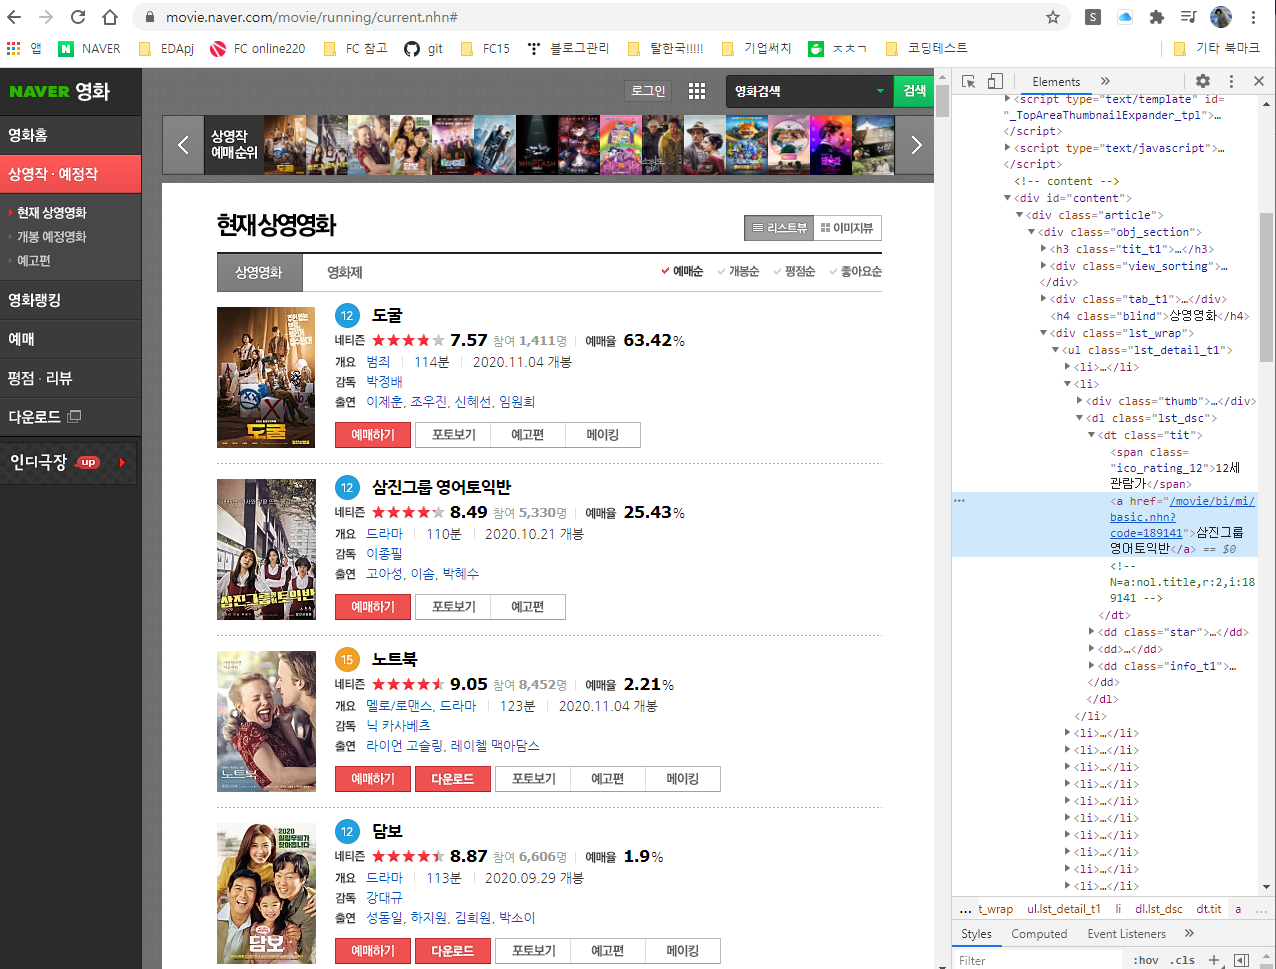
-> xpath 찾기

In [6]:
# //*[@id="content"]/div[1]/div[1]/div[3]/ul/li[2]/dl/dt/a 
# -> 모든 li를 다 가져오기 위해 li[2] 말고 li 라고 해 준다.

# 가져온게 link 데이터니까 /@href 붙여준다

links = response.xpath(
    '//*[@id="content"]/div[1]/div[1]/div[3]/ul/li/dl/dt/a/@href')
len(links), links[0]

(142,
 <Selector xpath='//*[@id="content"]/div[1]/div[1]/div[3]/ul/li/dl/dt/a/@href' data='/movie/bi/mi/basic.nhn?code=193194'>)

In [7]:
links = response.xpath(
    '//*[@id="content"]/div[1]/div[1]/div[3]/ul/li/dl/dt/a/@href').extract()
len(links), links[0]

(142, '/movie/bi/mi/basic.nhn?code=193194')

In [8]:
# url을 붙여주는 response의 함수를 이용한다. -> domain 이 추가돼서 나온다.
# -> 우리가 진짜 필요로 하는 full URL을 얻을수있따!!

link = response.urljoin(links[0])
link

'https://movie.naver.com/movie/bi/mi/basic.nhn?code=193194'

In [9]:
##가져온 풀url 링크데이터 -> yield 해줌 -> 받은 함수가 상세페이지에서 필요한 데이터들을 item 으로 만듬 
## -> csv로 저장

In [10]:
# 상세 데이터 수집
req = requests.get(link)
response = TextResponse(req.url, body=req.text, encoding="utf-8")

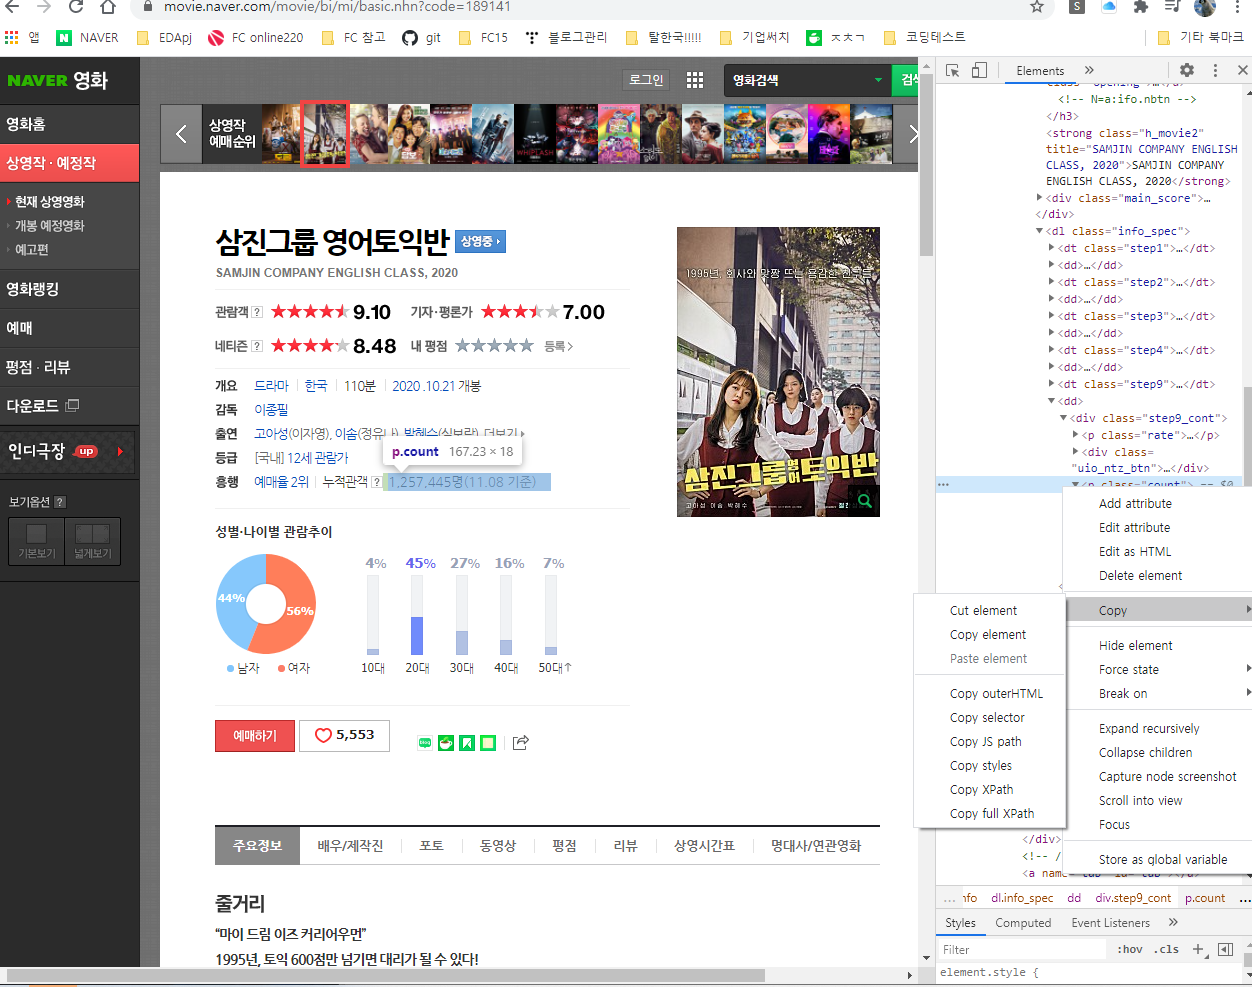
-> Copy Xpath

In [11]:
## xpath 들고와서  /text() 추가한다
title = response.xpath(
    '//*[@id="content"]/div[1]/div[2]/div[1]/h3/a[1]/text()').extract()
count = response.xpath(
    '//*[@id="content"]/div[1]/div[2]/div[1]/dl/dd[5]/div/p[2]/text()').extract()
star = response.xpath(
    '//*[@id="actualPointPersentBasic"]/div/em/text()').extract()
star = "".join(star)   # 리스트로 되어있는 데이터를 하나로 합치기
title, count, star

(['도굴'], ['612,179명'], '8.87')

### 4. spider 작성

In [99]:
%%writefile naver_movie/naver_movie/spiders/spider.py
import scrapy
from naver_movie.items import NaverMovieItem


class MovieSpider(scrapy.Spider):
    name = "NaverMovie"
    allow_domain = ["https://movie.naver.com"]
    start_urls = ["https://movie.naver.com/movie/running/current.nhn"]

    def parse(self, response):
        links = response.xpath('//*[@id="content"]/div[1]/div[1]/div[3]/ul/li/dl/dt/a/@href').extract()
        for link in links:
            link = response.urljoin(link)
            yield scrapy.Request(link, callback=self.parse_page_contents)

    def parse_page_contents(self, response):
        item = NaverMovieItem()
        item["title"] = response.xpath('//*[@id="content"]/div[1]/div[2]/div[1]/h3/a[1]/text()').extract()[0]
        try:
            item["count"] = response.xpath('//*[@id="content"]/div[1]/div[2]/div[1]/dl/dd[5]/div/p[2]/text()').extract()[0]
        except:
            item["count"] = "0명"
        star = response.xpath('//*[@id="actualPointPersentBasic"]/div/em/text()').extract()
        item["star"] = "".join(star)
        yield item

Overwriting naver_movie/naver_movie/spiders/spider.py


In [100]:
# %%writefile naver_movie/naver_movie/spiders/spider.py

# import scrapy
# from naver_movie.items import NaverMovieItem

# class MovieSpider(scrapy.Spider):  # scrapy.Spider를 상속하는 MovieSpider클래스
#     name = "NaverMovie"
#     allow_domain = ["https://movie.naver.com"]
#     start_urls = ["https://movie.naver.com/movie/running/current.nhn"]
    
#     def parse(self, response):  # parse 함수에 response 한다~~
#         links = response.xpath('//*[@id="content"]/div[1]/div[1]/div[3]/ul/li/dl/dt/a/@href')[:10].extract()
# #         links = [response.urljoin(link) for link in links]
#         for link in links:
#             link = response.urljoin(link)
#             yield scrapy.Request(link, callback=self.parse_page_contents)
            
#     def parse_page_contents(self, response):
#         item = NaverMovieItem()
#         item["title"] = response.xpath('//*[@id="content"]/div[1]/div[2]/div[1]/h3/a[1]/text()').extract()[0]
#         try:
#             item["count"] = response.xpath('//*[@id="content"]/div[1]/div[2]/div[1]/dl/dd[5]/div/p[2]/text()').extract()[0]
#         except:
#             item["count"] = "0명"
#         star = response.xpath('//*[@id="actualPointPersentBasic"]/div/em/text()').extract()
#         item["star"] = "".join(star)
#         yield item

Overwriting naver_movie/naver_movie/spiders/spider.py


### 5. Scrapy 실행

In [101]:
%%writefile run.sh
cd naver_movie
scrapy crawl NaverMovie -o naver_movie.csv

Overwriting run.sh


In [102]:
!chmod +x run.sh

In [103]:
!./run.sh

2020-11-10 14:21:06 [scrapy.utils.log] INFO: Scrapy 2.4.0 started (bot: naver_movie)
2020-11-10 14:21:06 [scrapy.utils.log] INFO: Versions: lxml 4.6.1.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 20.3.0, Python 3.6.9 (default, Oct 19 2020, 01:13:33) - [GCC 7.5.0], pyOpenSSL 19.1.0 (OpenSSL 1.1.1h  22 Sep 2020), cryptography 3.2.1, Platform Linux-5.4.0-1029-aws-x86_64-with-debian-buster-sid
2020-11-10 14:21:06 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.epollreactor.EPollReactor
2020-11-10 14:21:06 [scrapy.crawler] INFO: Overridden settings:
{'BOT_NAME': 'naver_movie',
 'NEWSPIDER_MODULE': 'naver_movie.spiders',
 'SPIDER_MODULES': ['naver_movie.spiders']}
2020-11-10 14:21:06 [scrapy.extensions.telnet] INFO: Telnet Password: 45bcd2465aeb927e
2020-11-10 14:21:06 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extens

### 6. settings.py 파일 변경
- Forbidden by robots.txt

In [34]:
!head -n 25 naver_movie/naver_movie/settings.py | tail -n 5


# Configure maximum concurrent requests performed by Scrapy (default: 16)
#CONCURRENT_REQUESTS = 32

# Configure a delay for requests for the same website (default: 0)


In [35]:
!sed -i 's/ROBOTSTXT_OBEY = True/ROBOTSTXT_OBEY = False/' naver_movie/naver_movie/settings.py

In [36]:
!./run.sh

2020-11-10 14:11:29 [scrapy.utils.log] INFO: Scrapy 2.4.0 started (bot: naver_movie)
2020-11-10 14:11:29 [scrapy.utils.log] INFO: Versions: lxml 4.6.1.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 20.3.0, Python 3.6.9 (default, Oct 19 2020, 01:13:33) - [GCC 7.5.0], pyOpenSSL 19.1.0 (OpenSSL 1.1.1h  22 Sep 2020), cryptography 3.2.1, Platform Linux-5.4.0-1029-aws-x86_64-with-debian-buster-sid
2020-11-10 14:11:29 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.epollreactor.EPollReactor
2020-11-10 14:11:29 [scrapy.crawler] INFO: Overridden settings:
{'BOT_NAME': 'naver_movie',
 'NEWSPIDER_MODULE': 'naver_movie.spiders',
 'SPIDER_MODULES': ['naver_movie.spiders']}
2020-11-10 14:11:29 [scrapy.extensions.telnet] INFO: Telnet Password: 6b7d99553ad69a5c
2020-11-10 14:11:29 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extens

In [37]:
import pandas as pd

In [38]:
df = pd.read_csv("naver_movie/naver_movie.csv")
df.tail(2)

,count,star,title
569,"1,278,622명",9.11,삼진그룹 영어토익반
570,0명,8.97,미스터트롯: 더 무비
